# Load Evaluation Data and merge with conversations

In [2]:
from glob import glob
from sklearn.model_selection import train_test_split

eval_files = glob("../../output/evals_dim2/*.json")
train_files, test_files = train_test_split(eval_files, test_size=0.2)

len(train_files), len(test_files)

(20, 5)

In [7]:
import os
import re
import json

def read_transcript(data_dir, filename):
    """Read the content of a transcript file and format it as list of messages."""
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):

        return f"Transcript not found in {file_path}"

    chat = []
    with open(file_path, "r", encoding="utf-8") as file:
        conversation_text = file.read().strip()
        pattern = r"(seeker:|supporter:)(.*?)(?=(seeker:|supporter:|$))"
        matches = re.findall(pattern, conversation_text, re.DOTALL)
        conversation = [(speaker.strip(), message.strip()) for speaker, message, _ in matches]

        for speaker, message in conversation:
            chat.append(message)

    return chat

def merge_with_conv(files):
    result = []
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)

        for eval_obj in data:
            pid = eval_obj['pid']
            model_a = eval_obj['model_a'].replace('output-exp2-', '')
            model_b = eval_obj['model_b'].replace('output-exp2-', '')

            updated_obj = eval_obj.copy()

            transcript_a = read_transcript('../../output/exp2/', f'output-exp2-{model_a}_{pid}.txt')
            transcript_b = read_transcript('../../output/exp2/', f'output-exp2-{model_b}_{pid}.txt')

            updated_obj['conv_a'] = transcript_a
            updated_obj['conv_b'] = transcript_b

            result.append(updated_obj)

    return result
    
train_data = merge_with_conv(train_files)
test_data = merge_with_conv(test_files)
            

In [8]:
train_data[0]

{'pid': 'e0a52f46-5b93-40cc-b8e0-76ac9eac6c88',
 'model_a': 'output-exp2-hillprompt_gpt-4o-mini',
 'model_b': 'output-exp2-nodir_meta-llama-Llama-3.1-8B-Instruct',
 'Exploration': {'Empathic Understanding': '## Reasoning\n\nTo evaluate the two support models—Model A and Model B—based on **Empathic Understanding**, we analyze how each model conveys a deep understanding of the seeker\'s inner emotional world through reflections of feelings and alignment with the seeker\'s subjective experience.\n\n### **Model A (Support Model A)**\n\n1. **Initial Acknowledgment:**\n   - **Supporter:** "I’m glad you reached out and shared that with me. It sounds like you’ve been feeling quite overwhelmed..."\n   - **Analysis:** Model A immediately acknowledges the seeker\'s feelings of being overwhelmed, validating their emotional state.\n\n2. **Deep Reflection:**\n   - **Supporter:** "It sounds like you’re carrying a heavy load right now... Your feelings of exhaustion and worry about the worst-case scena

# Preprocess files into prompts

In [11]:
import json

with open('../../data/exploration_rubric3.jsonl', 'r') as f:
    rubric = json.load(f)

with open('./distillation_prompt', 'r') as f:
    prompt_template = f.read().strip()
    

def preprocess_to_prompt_format_jsonl(data):
    result = []
    
    for eval_obj in data:
        for topic in rubric:
            for subtopic, description in rubric[topic].items():
                prompt = prompt_template.format(
                    topic=topic,
                    description=description,
                    conv_a = eval_obj['conv_a'],
                    conv_b = eval_obj['conv_b'],
                )
                judge = eval_obj[topic][subtopic]
                result.append({'messages':[
                    {'role': 'system', 'content': 'You are a helpful AI assistant'},
                    {'role': 'user', 'content': prompt},
                    {'role': 'assistant', 'content': judge}
                ]})
        
    return result

preprocessed_train_data = preprocess_to_prompt_format_jsonl(train_data)
preprocessed_test_data = preprocess_to_prompt_format_jsonl(test_data)\

len(preprocessed_train_data), len(preprocessed_test_data)


(3300, 825)

In [13]:
import json


def write_jsonl(data, path):
    with open(path, 'w') as f:
        for d in data:
            f.write(f"{json.dumps(d)}\n")

write_jsonl(preprocessed_train_data, 'train.jsonl')
write_jsonl(preprocessed_test_data, 'test.jsonl')

In [18]:
txt = preprocessed_train_data[0]['messages'][1]['content'] + preprocessed_train_data[0]['messages'][2]['content']
len(txt.replace('\n', ' ').split())

4573

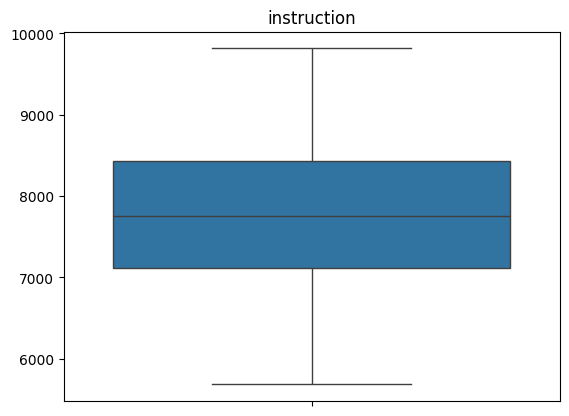

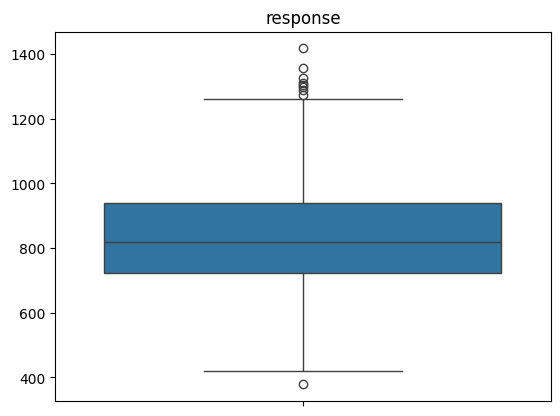

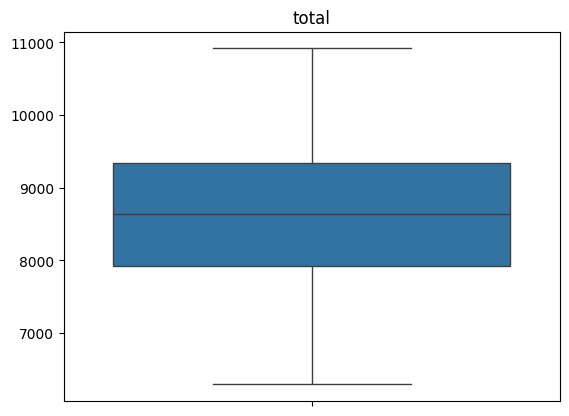

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


def get_data_stats(data):
    inst_toks = []
    resp_toks = []
    total_toks = []
    
    for d in data:
        inst = d['messages'][1]['content']
        resp = d['messages'][2]['content']
        inst_toks.append(len(inst.replace('\n', ' ').split())*1.5)
        resp_toks.append(len(resp.replace('\n', ' ').split())*1.5)
        total_toks.append(inst_toks[-1] + resp_toks[-1])

    sns.boxplot(inst_toks)
    plt.title("instruction")
    plt.show()
    sns.boxplot(resp_toks)
    plt.title("response")
    plt.show()
    sns.boxplot(total_toks)
    plt.title("total")
    plt.show()

get_data_stats(preprocessed_test_data)